In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys,os
sys.path.append(os.path.abspath(os.path.join("..")))
from config import *
import umap 

/mnt/c/Users/Lenovo/Documents/project/capstone_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(vcf_path+"/NOD2VariantsCounts.csv")
df.drop(columns=['patient_id','UTR3','UTR5'],inplace=True)  

In [3]:
df

,exonic,label
0,4,0
1,2,1
2,5,1
3,2,0
4,2,0
...,...,...
106,4,0
107,6,1
108,4,0
109,3,1


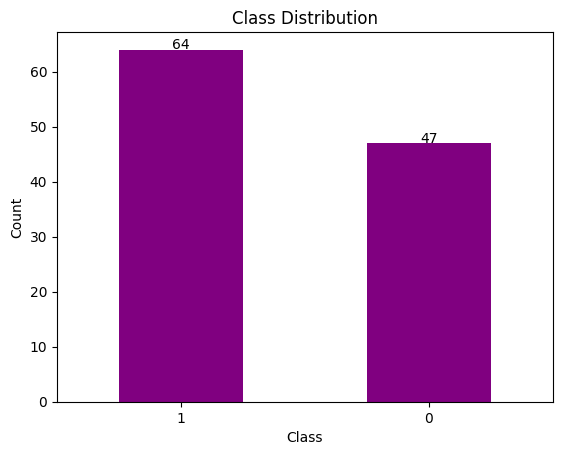

In [4]:
class_counts = df['label'].value_counts()
ax = class_counts.plot(kind='bar', color='purple', rot=0)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
for i, count in enumerate(class_counts):
    ax.text(i, count + 0.1, str(count), ha='center')
plt.show()

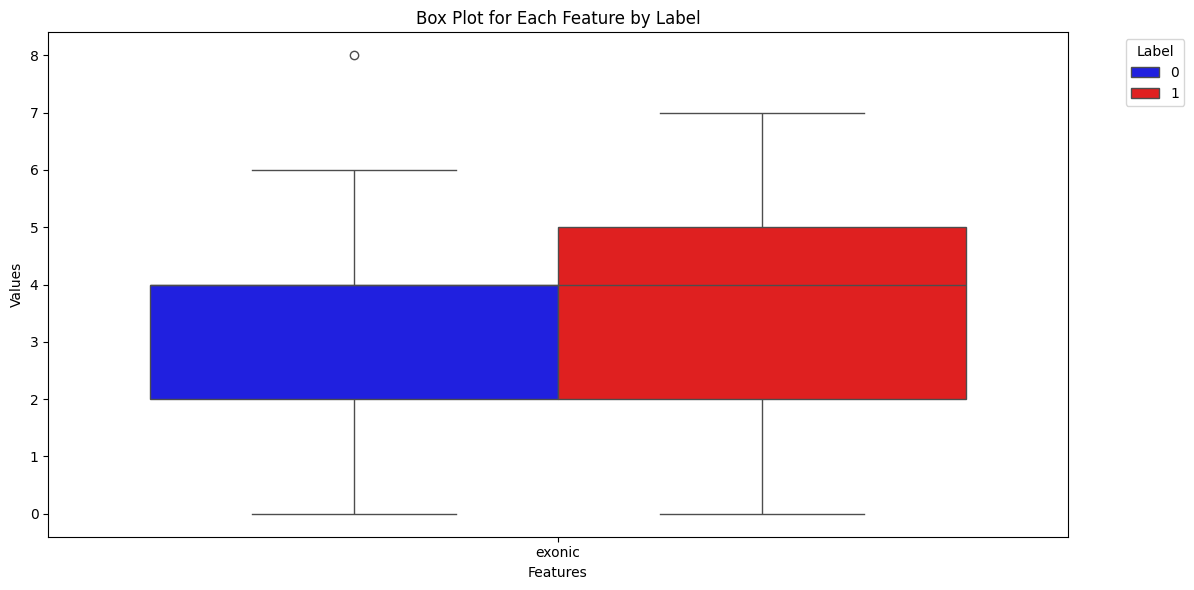

In [5]:
df_melted = df.melt(id_vars='label', var_name='Feature', value_name='Value')
palette = {0: 'blue', 1: 'red'}
plt.figure(figsize=(12, 6))  # Adjust figure size here
sns.boxplot(x='Feature', y='Value', hue='label', data=df_melted, palette=palette)
plt.title('Box Plot for Each Feature by Label')
plt.xlabel('Features')
plt.ylabel('Values')
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() 
plt.show()

ValueError: The number of passed axes must be 2, the same as the output plot

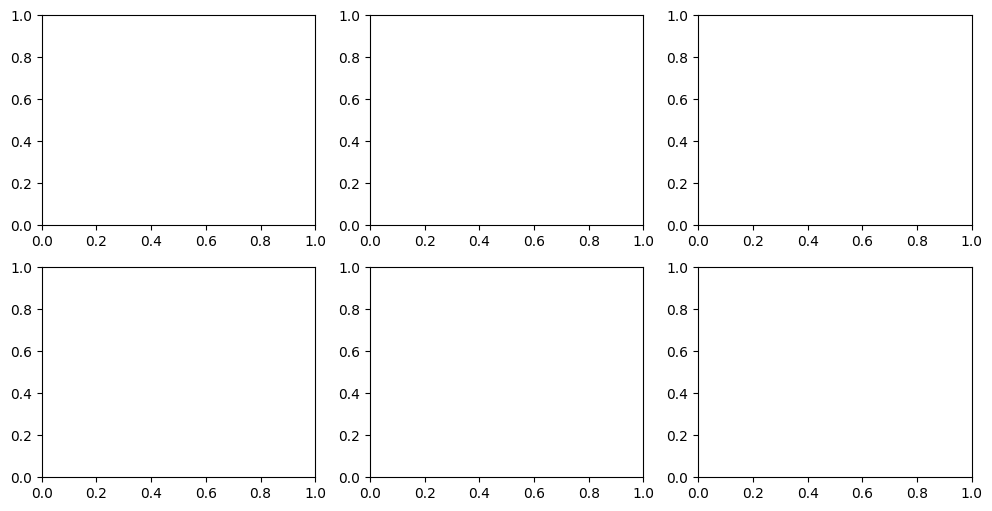

In [59]:
# Filter the DataFrame for label == 0 and label == 1
df_label_0 = df[df['label'] == 0]
df_label_1 = df[df['label'] == 1]
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
# Plot histogram for label 0
df_label_0.drop('label', axis=1).hist(bins=30, color='blue', alpha=0.7, ax=axes[0])
# Plot histogram for label 1
df_label_1.drop('label', axis=1).hist(bins=30, color='red', alpha=0.7, ax=axes[1])
# Adjust layout
plt.tight_layout()
plt.show()

In [6]:
outliers = {}
for column in df.columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1 # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[column] = df[column][(df[column] < lower_bound) | (df[column] > upper_bound)]
print("Outliers detected:")
for feature, outlier_values in outliers.items():
    if not outlier_values.empty:
        print(f"{feature}: {outlier_values.tolist()}")
    else:
        print(f"{feature}: No outliers")

Outliers detected:
exonic: No outliers
label: No outliers


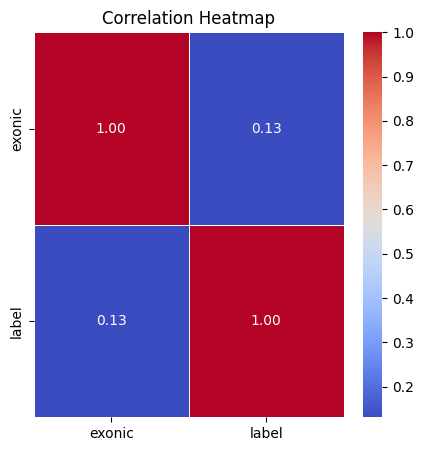

In [7]:
corr = df.corr()
plt.figure(figsize=(5, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

/mnt/c/Users/Lenovo/Documents/project/capstone_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


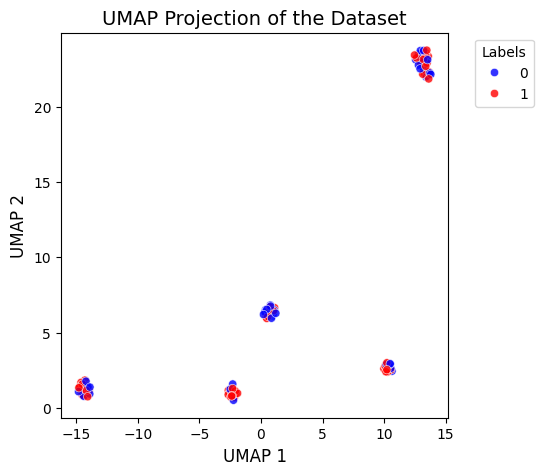

In [8]:
label = df['label']
reducer = umap.UMAP(metric='euclidean')
embedding = reducer.fit_transform(df.drop(columns=['label']))  # Drop the label column before fitting
plt.figure(figsize=(5, 5))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=label, palette=palette, alpha=0.8)
plt.title('UMAP Projection of the Dataset', fontsize=14)
plt.xlabel('UMAP 1', fontsize=12)
plt.ylabel('UMAP 2', fontsize=12)
plt.legend(title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.show()


splitting

In [9]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['label'])  # Features (independent variables)
y = df['label']  # Target variable (dependent variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

Training set size: (88, 1), Testing set size: (23, 1)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

logistic regression

In [12]:
# Initialize and train logistic regression model
logistic = LogisticRegression(random_state=42)
logistic.fit(X_train, y_train)
# Make predictions
y_pred = logistic.predict(X_test)
# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6087

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.59      1.00      0.74        13

    accuracy                           0.61        23
   macro avg       0.80      0.55      0.46        23
weighted avg       0.77      0.61      0.50        23



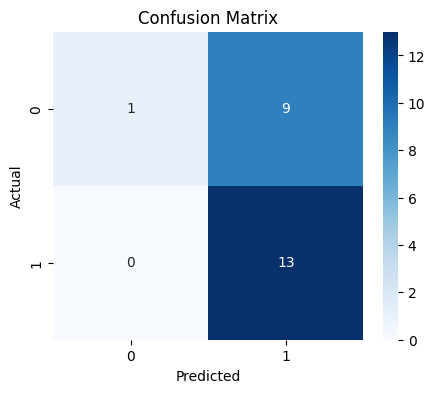

In [13]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=logistic.classes_, yticklabels=logistic.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

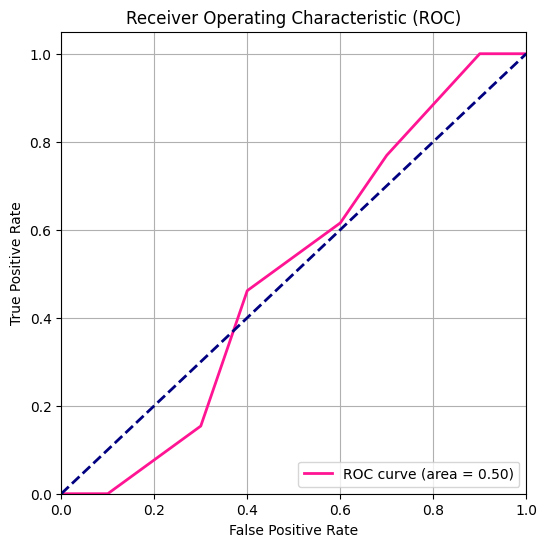

In [14]:
# Get probability scores for the positive class (label = 1)
y_probs = logistic.predict_proba(X_test)[:, 1]
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='deeppink', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

ensemble

Accuracy: 0.5652

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.20      0.29        10
           1       0.58      0.85      0.69        13

    accuracy                           0.57        23
   macro avg       0.54      0.52      0.49        23
weighted avg       0.54      0.57      0.51        23



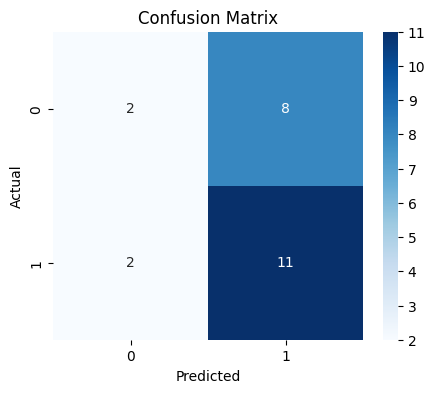

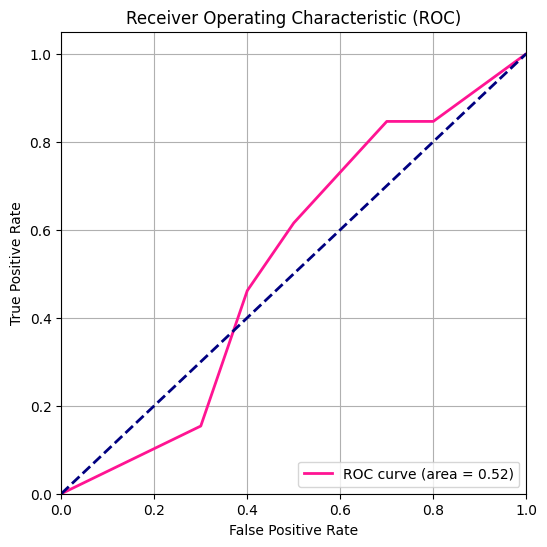

In [ ]:


# Load & Split Data (Assuming you have X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train_scaled, y_train)

# Make predictions
y_pred = xgb.predict(X_test_scaled)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=xgb.classes_, yticklabels=xgb.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Get probability scores for the positive class
y_probs = xgb.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='deeppink', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Accuracy: 0.5217

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.30      0.35        10
           1       0.56      0.69      0.62        13

    accuracy                           0.52        23
   macro avg       0.50      0.50      0.49        23
weighted avg       0.50      0.52      0.50        23



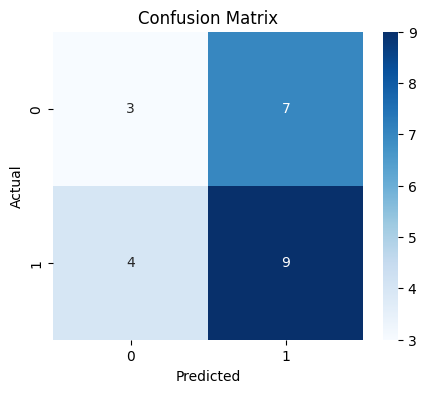

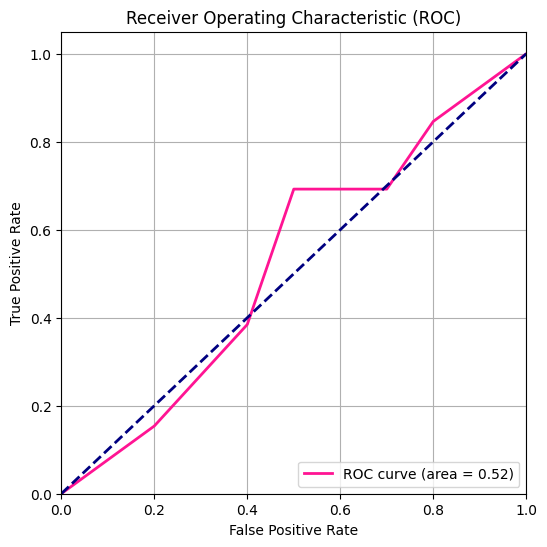

In [21]:
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Get probability scores for the positive class (label = 1)
y_probs = svm_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='deeppink', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Accuracy: 0.6087

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.30      0.40        10
           1       0.61      0.85      0.71        13

    accuracy                           0.61        23
   macro avg       0.61      0.57      0.55        23
weighted avg       0.61      0.61      0.58        23



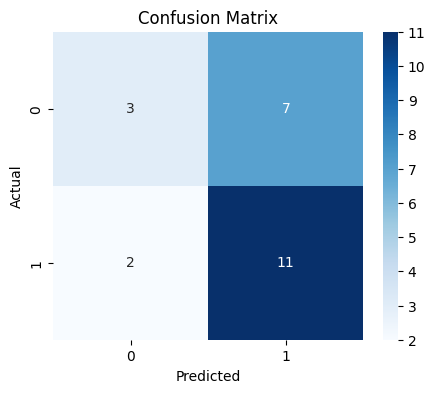

ROC AUC: 0.5154


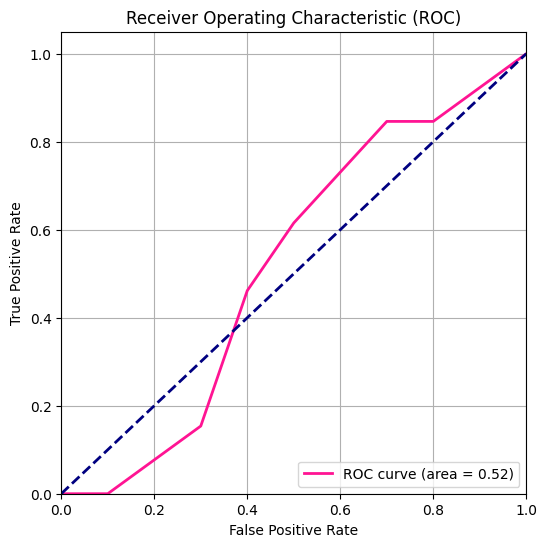

In [ ]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Get probability scores for the positive class (label = 1)
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='deeppink', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
